<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Sistema inteligente para ayudar a detectar posibles reclamos (glosas) en las cuentas médicas previo al cobro, de una clínica en Colombia - Audimed</h1></center>
<center><h2>Trabajo Fin de Master<br>Máster Universitario en Análisis y Visualización de Datos Masivos / Visual Analytics and Big Data</h2></center>

<h3>Presentado por: Jacqueline Guzmán Rodriguez</h3>
<h4>Tipo de trabajo: Desarrollo Software <br>
Director: Juan Carlos Rincon Acuña <br>
Fecha: Junio/2024</h4>

<h3> <font color="#040078">Notebook de modelado de los datos</font></h3>
<h4></h4>
<h5><font color="#C62400">Licencia del Notebook CC BY-NC-SA 4.0 DEED <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/" target="_blank]">https://creativecommons.org/licenses/by-nc-sa/4.0/</a></font></h5/>

## Importación de librerias necesarias

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn_evaluation import plot

## Carga de archivo con datos transformados claims.cvs
#### Se pueden descargar los datos de la plataforma kaggle en el siguiente link: 
##### https://www.kaggle.com/datasets/jacquelineguzman/claims-of-medical-billing/

In [2]:
# Read file CSV Download of https://www.kaggle.com/datasets/jacquelineguzman/claims-of-medical-billing/
file_cvs = "claims.csv"
# Create dataframe with information of file CSV
df = pd.read_csv(file_cvs, delimiter=',', encoding='utf-8')

## Tratamiento de datos previos a la aplicación del modelo de clasificación
##### Se define como variable objetivo la marca de si el registro tiene reclamación o no (CLAIM)

In [3]:
# Define colums target (CLAIM)
columns = df.columns
target = "CLAIM"
x_columns = columns.drop(target)

##### Se actualizan las variables para manejar tipos de datos a 32 bits, dado que usa menos recurso de memoria.

In [4]:
# Update datatype int64 to int32 and float64 to float32, because it is necessary to use less RAM
float_columns = ['QUANTITY_PRODUCT_SERVICE', 'SALES_PRICE', 'INVOICED_PRICE']
int_columns = columns.drop(float_columns)
df[float_columns]=df[float_columns].astype(np.float32)
df[int_columns]=df[int_columns].astype(int)

##### Para facilitar los calculos del algoritmo se normaliza la información de las variables de entrada para que manejen rangos numericos entre cero (0) y uno (1), esto se hace con la función MinMaxScaler

In [5]:
# Normalize data via MinMaxScaler function
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=columns)

##### Se verifica la distribucción de la variable objetivo (CLAIM), donde se observa que es desbalanceda.

In [6]:
# Distribution of the target variable (CLAIM)
print(str(target)+':\n'+str(df[target].unique())+'\n')
print(df[target].value_counts())

CLAIM:
[0. 1.]

CLAIM
0.0    6104323
1.0        120
Name: count, dtype: int64


##### Se crean los dataframe de entrada (ValX) y salida (ValY) 

In [7]:
# Create dataframe with int variables (ValX) and target variable (ValY)
ValX = df.drop(columns=target)
ValY = df[target]

##### Se crean los dataframe de entrenamiento y validación, necesarios para el entrenamiento del modelo, se definió un 15% de los datos para los dataframe de validación

In [8]:
# Set training and validation data
X_train, X_validation, Y_train, Y_validation = train_test_split(ValX, ValY, test_size=0.15, random_state=1, shuffle=True)

In [9]:
X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

((5188776, 53), (5188776,), (915667, 53), (915667,))

##### Para no trabajar con datos de entrenamiento desbalanceados, se aplica la técnica de sobremuestreo (over-sampling) sobre los datos de entrenamiento (X_train y Y_train)

In [10]:
# Resampling the minority class using SMOTE stategy (Over-sampling)
sm = SMOTE(sampling_strategy='minority', random_state=42)

In [11]:
# Fit the model to generate the data.
X_train, Y_train = sm.fit_resample(X_train, Y_train)

C:\Users\jefe.sistemas\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jefe.sistemas\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [12]:
X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

((10377344, 53), (10377344,), (915667, 53), (915667,))

## Creación del modelo
##### Se escoge el algoritmo de Random Forest de clasificación, dado que tenemos una variable objetivo con dos clases (0, 1)
##### Para verificar los hiperparametros, se hicienron procesos de prueba y error obteniendo los siguientes: n_estimators=5, con 5 arboles es suficiente, y con 10 ramas tambien max_depth=10

In [13]:
#feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
NN_model = tf.keras.Sequential([\
  layers.Dense(106, activation='relu', input_shape=[len(X_train.keys())]),\
  layers.Dense(1, activation='hard_sigmoid', name='output')\
])
# hard_sigmoid

C:\ProgramData\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
NN_model.compile(\
    optimizer='adam',\
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),\
    metrics=['accuracy']\
)

In [15]:
NN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 106)                 │           5,724 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             107 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
NN_model.fit(X_train,Y_train,epochs=10)

Epoch 1/5
324292/324292 ━━━━━━━━━━━━━━━━━━━━ 220s 675us/step - accuracy: 0.9937 - loss: 0.5066
Epoch 2/5
324292/324292 ━━━━━━━━━━━━━━━━━━━━ 257s 660us/step - accuracy: 0.9996 - loss: 0.5034
Epoch 3/5
324292/324292 ━━━━━━━━━━━━━━━━━━━━ 163s 356us/step - accuracy: 0.9997 - loss: 0.5033
Epoch 4/5
324292/324292 ━━━━━━━━━━━━━━━━━━━━ 119s 365us/step - accuracy: 0.9997 - loss: 0.5033
Epoch 5/5
324292/324292 ━━━━━━━━━━━━━━━━━━━━ 118s 363us/step - accuracy: 0.9997 - loss: 0.5033


### Validación del modelo
##### Crear datase con los datos que predice el modelo (Y_predict), basado en los datos de validación X_validation

In [17]:
Y_predict = NN_model.predict(X_validation)

28615/28615 ━━━━━━━━━━━━━━━━━━━━ 8s 292us/step


In [18]:
Y_predict

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [19]:
Y_predict = tf.squeeze(Y_predict)

In [20]:
Y_predict

<tf.Tensor: shape=(915667,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [21]:
Y_predict = np.array([1 if x >= 0.5 else 0 for x in Y_predict])

In [22]:
Y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
print('Model accuracy: {0:0.4f}'. format(accuracy_score(Y_validation, Y_predict)))

Model accuracy score with 5 decision-trees : 0.9995


In [24]:
print("Prediction for test set: {}".format(Y_predict))

Prediction for test set: [0 0 0 ... 0 0 0]


##### Verificar la salida esperada con la salida de la predicción

In [25]:
mlr_diff = pd.DataFrame({'Actual value': Y_validation, 'Predicted value': Y_predict})
mlr_diff.tail(10)

,Actual value,Predicted value
3141433,0.0,0
3895887,0.0,0
2199388,0.0,0
2010216,0.0,0
5153739,0.0,0
6054309,0.0,0
1411925,0.0,0
596122,0.0,0
5236999,0.0,0
4092770,0.0,0


<Axes: title={'center': 'Class Balance for 1,831,334 Instances'}, ylabel='support'>

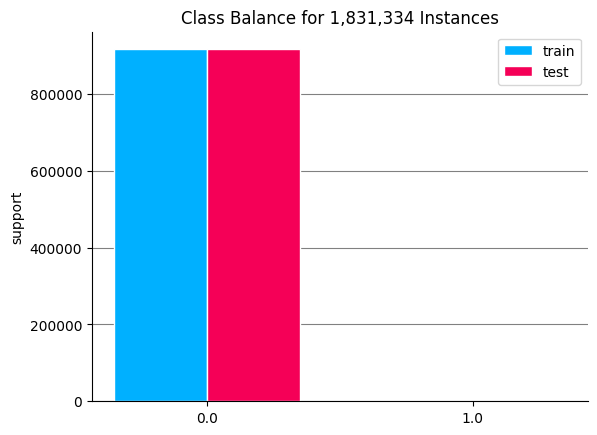

In [26]:
plot.target_analysis(mlr_diff['Actual value'], mlr_diff['Predicted value'])

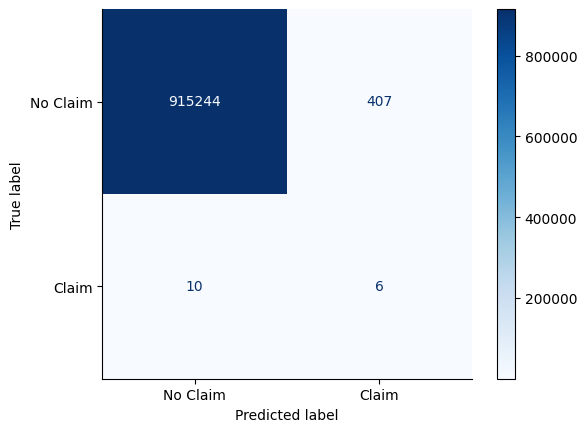

In [27]:
confusion_matrix = confusion_matrix(Y_validation, Y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Claim', 'Claim'])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [28]:
print(NN_model.evaluate(X_train, Y_train))

324292/324292 ━━━━━━━━━━━━━━━━━━━━ 97s 299us/step - accuracy: 0.9996 - loss: 0.6351
[0.5031690001487732, 0.9997894167900085]
